In [23]:
# Question 3
# (a)
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn
import random

df = pd.read_table("/Desktop/cs5785/hw3/OFG.txt", sep = "\s+")
data = df.values
print(data.shape)
print(data[:5])

(272, 2)
[[  3.6    79.   ]
 [  1.8    54.   ]
 [  3.333  74.   ]
 [  2.283  62.   ]
 [  4.533  85.   ]]


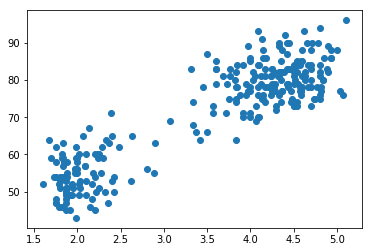

In [3]:
# (b)
plt.scatter(data[:,0], data[:,1])

In [24]:
# (c)-(d)
class GMM(object):
    def __init__(self, n = 2, max_iter = 500):
        self.n = n
        self.max_iter = max_iter

    def fit(self, X, persist=False, **kwargs):
        self.N, self.p = X.shape
        
        if len(kwargs) > 0:
            self.means = kwargs['means']
            self.covs = kwargs['cov']
            self.prior = kwargs['prior']
        else:
            # nc * p
            _ = np.arange(self.N)
            np.random.shuffle(_)
            _idx = _[:self.n]
            self.means = np.copy(X[_idx, :])
            #         print self.means

            # nc * p * p
            _X = X - np.mean(X, axis=0)
            _cov = np.dot(_X.T, _X) * np.identity(self.p) / float(self.N)
            self.covs = np.repeat(_cov[np.newaxis, :, :], self.n, axis=0)
            #         print self.covs

            # nc * 1
            self.prior = np.full((self.n, 1), 1.0 / self.n, dtype=float)
            #         print self.prior


        if persist:
            self.all_means = [self.means, ]
            self.all_covs = [self.means, ]
            self.all_prior = [self.prior, ]

        self.prob = np.zeros((self.N,))
        self.resp = np.zeros((self.n, self.N))
        for i in xrange(self.max_iter):
            resp, self.prob = self.E_step(X)

            if np.allclose(resp, self.resp):
                self.iter_times = i
                break

            _prior, _means, _covs = self.M_step(X, resp)

            if persist:
                self.all_means.append(_means)
                self.all_covs.append(_covs)

            self.resp = resp
            self.prior = _prior
            self.means = _means
            self.covs = _covs

        if not hasattr(self, "iter_times"):
            self.iter_times = self.max_iter

    def E_step(self, X):

        phi_s = np.array([mn.pdf(X, self.means[i], self.covs[i]) for i in range(self.n)])
        gamma_s = (self.prior * phi_s) / np.dot(self.prior.T, phi_s)

        return gamma_s, np.dot(phi_s.T, self.prior)

    def M_step(self, X, gamma_s):
        
        _prior = (np.sum(gamma_s, axis=1) / self.N)[:, np.newaxis]

        _gamma_sum = np.sum(gamma_s, axis=1) 
        _means = np.dot(gamma_s, X) / _gamma_sum[:, np.newaxis]
        _covs = np.empty((self.n, self.p, self.p))
        
        for _i in range(self.n):
            _diff = X - _means[_i]
            _gamma = gamma_s[_i]
            assert _gamma.shape == (self.N,)
            _covs[_i, :, :] = np.dot(_gamma * _diff.T, _diff) * np.identity(self.p) / _gamma_sum[_i]

        return _prior, _means, _covs

    def predict(self, X):
        if (self.iter_times < self.max_iter):
            _, prob = self.E_step(X)
            return prob
        else:
            print "Coefficients have not converged before maximum iteration!"

In [25]:
class KMeans():
    def __init__(self, max_iter=1000):
        self.max_iter = max_iter
        
    def fit(self, X, k):
        self.X = X
        self.N, self.p = X.shape
        self.k = k
        
        _ = set([])
        while len(_) < k:
            _.add(random.randint(0, self.N - 1))
        self.center = np.copy(X[tuple(_), :])
        assert self.center.shape == (self.k, self.p)
        
        self.status = np.zeros((self.N,))
        
        converge = False
        iter_count = 0
        while not converge and iter_count < self.max_iter:
            converge = True
            _status = np.apply_along_axis(self._get_center_idx, 1, X)
            
            if not np.array_equal(self.status, _status):
                converge = False
                self._update_center(_status)
                self.status = _status
            
            iter_count += 1
        self.iter_count = iter_count
        
    def _get_center_idx(self, x):
        return np.argmin(np.sum((self.center - x) ** 2, axis=1), axis=0)
        
    def _update_center(self, status):
        for i in range(self.k):
            _center = np.mean(self.X[status == i], axis=0)
            self.center[i] = _center
    
    def get_center(self):
        return self.center 
    
    def get_status(self):
        return self.status
    
    def get_cluster(self, k):
        return self.X[self.status == k]

In [28]:
def get_init_components():
    kmeans = KMeans()
    kmeans.fit(data, 2)
    _cluster0 = data[kmeans.status == 0]
    _cluster1 = data[kmeans.status == 1]
    _cov = np.empty((2, 2, 2))
    _cov[0, :, :] = np.dot(_cluster0.T, _cluster0) / float(len(_cluster0))
    _cov[1, :, :] = np.dot(_cluster1.T, _cluster1) / float(len(_cluster1))

    _prior = [float(len(_cluster0)) / len(data), float(len(_cluster1)) / len(data)]

    init_param = {}
    init_param['means'] = kmeans.center
    init_param['cov'] = _cov
    init_param['prior'] = np.array(_prior)[:, np.newaxis]
    return init_param

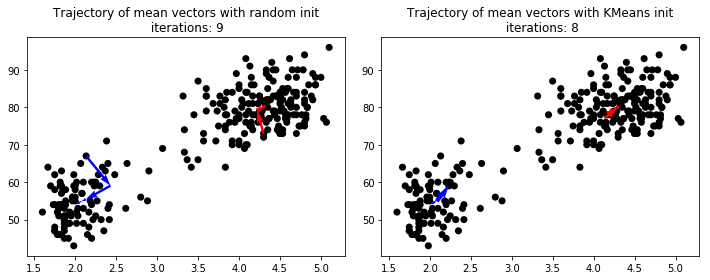

In [35]:
plt.figure(figsize=(10,4))

gmm = GMM(2)
gmm.fit(data,persist=True)

ttt = np.row_stack(tuple(gmm.all_means))
plt.subplot(1,2,1)
plt.scatter(data[:,0], data[:,1], s=[50]*len(data), linewidth=0, c='black')
x, y = ttt[::2, 0], ttt[::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='b')
x, y = ttt[1::2, 0], ttt[1::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='r')
plt.title("Trajectory of mean vectors with random init\n iterations: %d" % gmm.iter_times)

plt.subplot(1,2,2)
gmm = GMM(2)
gmm.fit(data,persist=True, **get_init_components())

ttt = np.row_stack(tuple(gmm.all_means))
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1], s=[50]*len(data), linewidth=0, c='black')
x, y = ttt[::2, 0], ttt[::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='b')
x, y = ttt[1::2, 0], ttt[1::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='r')
plt.title("Trajectory of mean vectors with KMeans init\n iterations: %d" % gmm.iter_times)
plt.tight_layout()

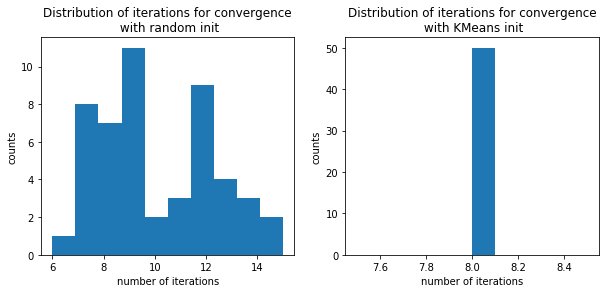

In [41]:
N = 50
iter_times1 = []
iter_times2 = []
for i in range(N):
    mdl1 = GMM(2)
    mdl2 = GMM(2)
    
    mdl1.fit(data)
    mdl2.fit(data, **get_init_componens())
    
    iter_times1.append(mdl1.iter_times)
    iter_times2.append(mdl2.iter_times)
    
plt.figure(figsize=(10,4)) 
plt.subplot(1,2,1)
_ = plt.hist(iter_times1) 
plt.ylabel("counts")
plt.xlabel("number of iterations")
plt.title("Distribution of iterations for convergence\n with random init")
plt.subplot(1,2,2)
_ = plt.hist(iter_times2)
plt.ylabel("counts")
plt.xlabel("number of iterations")
plt.title("Distribution of iterations for convergence\n with KMeans init")